In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import squeezenet1_0, resnet18
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import re
from PIL import Image
from tqdm import tqdm

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_path = '/content/drive/My Drive/adversarial_mnist'
weights_dir = f'{base_path}/model_weights'
adv_dir = f'{base_path}/large_adversarial_examples'
external_data_path = f'{base_path}/external_dataset/test'

if not os.path.exists(adv_dir):
    os.makedirs(adv_dir)

transform = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Mounted at /content/drive


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.04MB/s]


In [2]:
!pip install torchattacks
from torchattacks import PGD, MIFGSM, Pixle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: re

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

class ResNet18MNIST(nn.Module):
    def __init__(self):
        super(ResNet18MNIST, self).__init__()
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ConvNetTiny(nn.Module):
    def __init__(self):
        super(ConvNetTiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.fc1 = nn.Linear(8 * 13 * 13, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetWide(nn.Module):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetDeep(nn.Module):
    def __init__(self):
        super(ConvNetDeep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super(MiniGoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.inception = InceptionModule(64, 16, 32, 24, 8, 8, 16)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class MiniDenseNet(nn.Module):
    def __init__(self):
        super(MiniDenseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(16 * 14 * 14, 10)
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        c2 = torch.cat([out1, out2], 1)
        out3 = F.relu(self.conv3(c2))
        x = self.pool(out3)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [4]:
model_configs = []

model_configs.append(('LeNet_Standard', 'lenet.pth', LeNet5))
model_configs.append(('Squeeze_Standard', 'squeezenet.pth', SqueezeNetMNIST))

model_configs.append(('LeNet_Robust_PGD', 'lenet_pgd.pth', LeNet5))
model_configs.append(('Squeeze_Robust_PGD', 'squeezenet_pgd.pth', SqueezeNetMNIST))

model_configs.append(('LeNet_Robust_MIFGSM', 'lenet_mifgsm.pth', LeNet5))
model_configs.append(('Squeeze_Robust_MIFGSM', 'squeezenet_mifgsm.pth', SqueezeNetMNIST))

model_configs.append(('LeNet_Robust_Pixle', 'lenet_pixle.pth', LeNet5))
model_configs.append(('Squeeze_Robust_Pixle', 'squeezenet_pixle.pth', SqueezeNetMNIST))

zoo_architectures = [
    ('Linear', LinearModel), ('MLP', MLP), ('ConvTiny', ConvNetTiny),
    ('Simple', SimpleCNN), ('ConvWide', ConvNetWide), ('ConvDeep', ConvNetDeep),
    ('LeNet', LeNet5), ('MiniVGG', MiniVGG), ('Squeeze', SqueezeNetMNIST),
    ('MiniInception', MiniGoogLeNet), ('MiniDense', MiniDenseNet), ('ResNet', ResNet18MNIST)
]

for seed in range(2):
    for name, arch_cls in zoo_architectures:
        model_configs.append((f"{name}_s{seed}", f"{name.lower()}_s{seed}.pth", arch_cls))

all_names = [c[0] for c in model_configs]
n_models = len(all_names)

zoo_models = {}
for name, fname, arch_cls in tqdm(model_configs, desc="Loading All Models"):
    path = f"{weights_dir}/{fname}"
    if not os.path.exists(path):
        print(f"Warning: Model file not found {path}")
        continue
    m = arch_cls()
    try:
        m.load_state_dict(torch.load(path, map_location=device))
        m.to(device).eval()
        zoo_models[name] = m
    except:
        pass

Loading All Models: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


In [5]:
attack_configs = [
    ('PGD', PGD, {'eps': 0.3, 'alpha': 0.01, 'steps': 40}),
    ('MIFGSM', MIFGSM, {'c': 5, 'kappa': 0, 'steps': 1000, 'lr': 0.01}),
    ('Pixle', Pixle, {'restarts': 10})
]

for atk_name, atk_class, atk_params in attack_configs:

    if atk_name == 'PGD':
        current_focus = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust_PGD', 'Squeeze_Robust_PGD']
    elif atk_name == 'MIFGSM':
        current_focus = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust_MIFGSM', 'Squeeze_Robust_MIFGSM']
    else:
        current_focus = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust_Pixle', 'Squeeze_Robust_Pixle']

    for name in tqdm(current_focus, desc=f"Generating {atk_name}"):
        if name not in zoo_models:
            continue

        fname = [x[1] for x in model_configs if x[0] == name][0]
        save_path = f"{adv_dir}/500_adv_{atk_name}_{fname}"

        if os.path.exists(save_path):
            continue

        model = zoo_models[name]
        try:
            adversary = atk_class(model, **atk_params)
        except:
            adversary = atk_class(model)

        adv_list, clean_list, lbl_list = [], [], []

        for data, target in test_loader:
            if len(adv_list) * test_loader.batch_size >= 500:
                break

            data, target = data.to(device), target.to(device)
            adv = adversary(data, target)

            adv_list.append(adv.cpu())
            clean_list.append(data.cpu())
            lbl_list.append(target.cpu())

        adv_imgs = torch.cat(adv_list)[:500]
        clean_imgs = torch.cat(clean_list)[:500]
        labels = torch.cat(lbl_list)[:500]

        with torch.no_grad():
            preds = model(adv_imgs.to(device)).argmax(1)
            rob_acc = (preds == labels.to(device)).float().mean().item() * 100

            clean_preds = model(clean_imgs.to(device)).argmax(1)
            clean_acc = (clean_preds == labels.to(device)).float().mean().item() * 100

        torch.save({
            'clean': clean_imgs,
            'adv': adv_imgs,
            'lbl': labels,
            'score_clean': clean_acc,
            'score_robust': rob_acc
        }, save_path)

Generating Pixle: 100%|██████████| 4/4 [00:00<00:00, 4700.82it/s]


In [6]:
def calculate_metrics(attack_name, focus_models):
    matrix_acc = np.zeros((n_models, n_models))

    zoo_data = {}
    for name in all_names:
        fname = [x[1] for x in model_configs if x[0] == name][0]
        path = f"{adv_dir}/500_adv_{attack_name}_{fname}"
        if os.path.exists(path):
            zoo_data[name] = torch.load(path)

    for i, src_name in enumerate(tqdm(focus_models, desc="Building Matrix")):
        if src_name not in zoo_data: continue

        data = zoo_data[src_name]
        adv = data['adv'].to(device)
        lbl = data['lbl'].to(device)

        # Attack all Zoo models
        for j, tgt_name in enumerate(all_names):
            if tgt_name not in zoo_models: continue

            tgt_model = zoo_models[tgt_name]
            with torch.no_grad():
                preds = tgt_model(adv).argmax(1)
                acc = (preds == lbl).float().mean().item() * 100

                src_idx = all_names.index(src_name)
                matrix_acc[src_idx, j] = acc

    results = {
        'clean': [], 'white': [], 'zoo_def': [], 'zoo_off': [], 'matrix': matrix_acc
    }

    focus_indices = [all_names.index(n) for n in focus_models]

    for idx in focus_indices:
        name = all_names[idx]
        if name in zoo_data:
            results['clean'].append(zoo_data[name]['score_clean'])
        else:
            results['clean'].append(0)

        results['white'].append(matrix_acc[idx, idx])

        incoming = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
        results['zoo_def'].append(np.mean(incoming) if incoming else 0)

        outgoing = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
        results['zoo_off'].append(np.mean(outgoing) if outgoing else 0)

    return results

In [7]:
def load_global_external_dataset(path, ref_dataset):
    if not os.path.exists(path):
        print(f"Path not found: {path}")
        return None, None

    all_imgs = []
    all_lbls = []

    transform = transforms.Compose([transforms.ToTensor()])
    pattern = re.compile(r'(\d+)')

    print(f"Scanning {path} recursively for ALL external adversarial images...")

    count = 0
    for root, dirs, files in os.walk(path):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                match = pattern.search(fname)
                if match:
                    idx = int(match.group(1))
                    if 0 <= idx < len(ref_dataset.targets):
                        try:
                            img_path = os.path.join(root, fname)
                            img = Image.open(img_path).convert('L')
                            all_imgs.append(transform(img))
                            all_lbls.append(ref_dataset.targets[idx])
                            count += 1
                        except:
                            pass

    if not all_imgs:
        print("No valid images found.")
        return None, None

    print(f"Aggregated {count} images into Global External Dataset.")
    return torch.stack(all_imgs), torch.tensor(all_lbls)

global_ext_imgs, global_ext_lbls = load_global_external_dataset(external_data_path, test_set)

if global_ext_imgs is not None:
    global_ext_imgs = global_ext_imgs.to(device)
    global_ext_lbls = global_ext_lbls.to(device)

def get_external_scores(model_list):
    scores = []
    if global_ext_imgs is None:
        return [0] * len(model_list)

    for name in model_list:
        if name in zoo_models:
            with torch.no_grad():
                preds = zoo_models[name](global_ext_imgs).argmax(1)
                acc = (preds == global_ext_lbls).float().mean().item() * 100
                scores.append(acc)
        else:
            scores.append(0)
    return scores

Path not found: /content/drive/My Drive/adversarial_mnist/external_dataset/test


Building Matrix: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


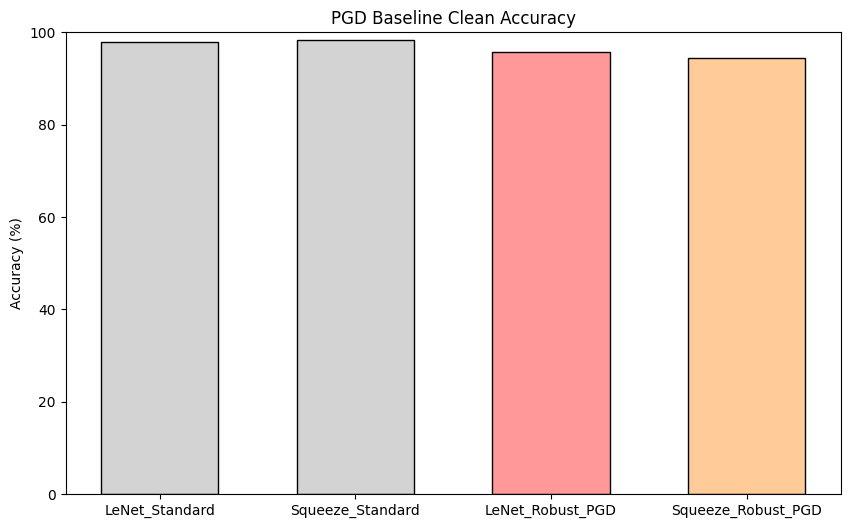

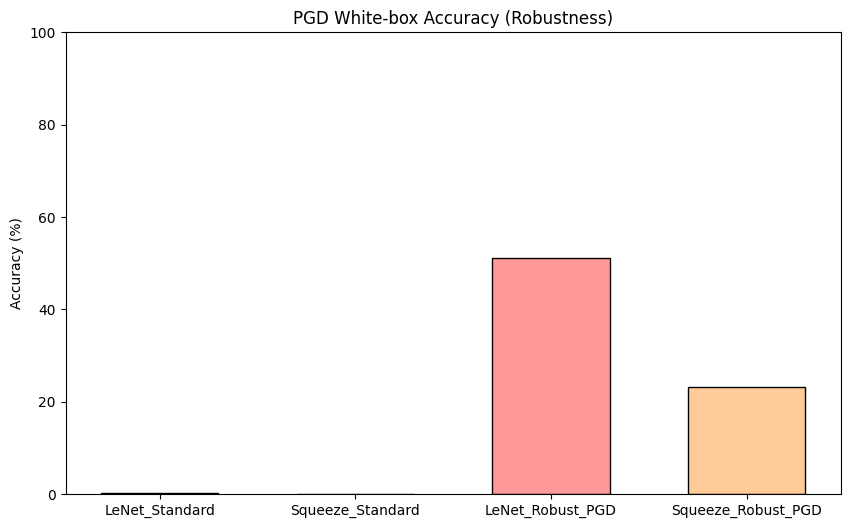

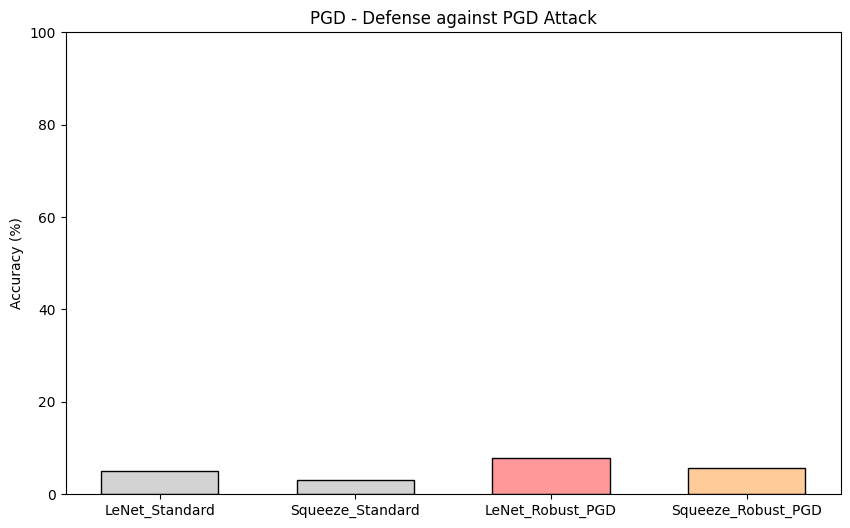

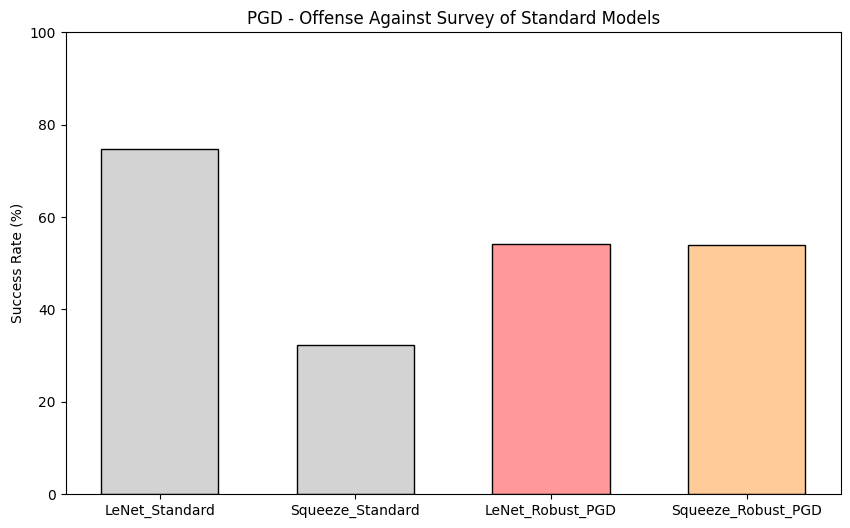

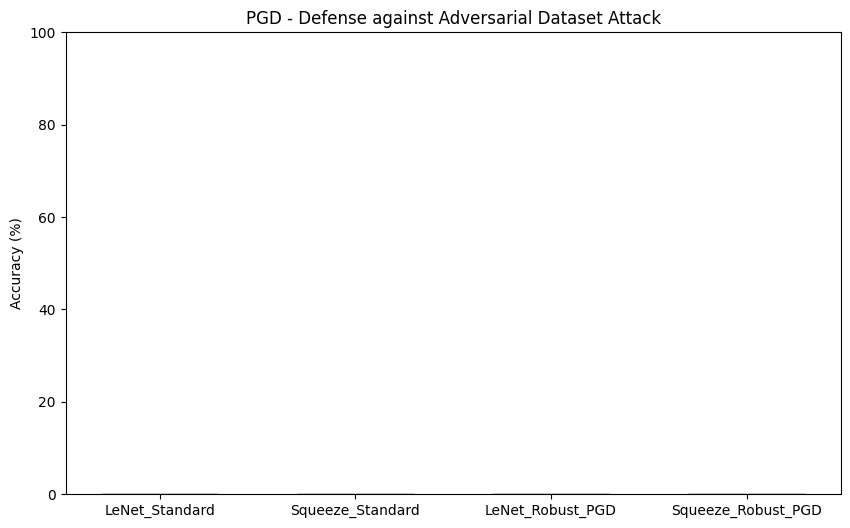

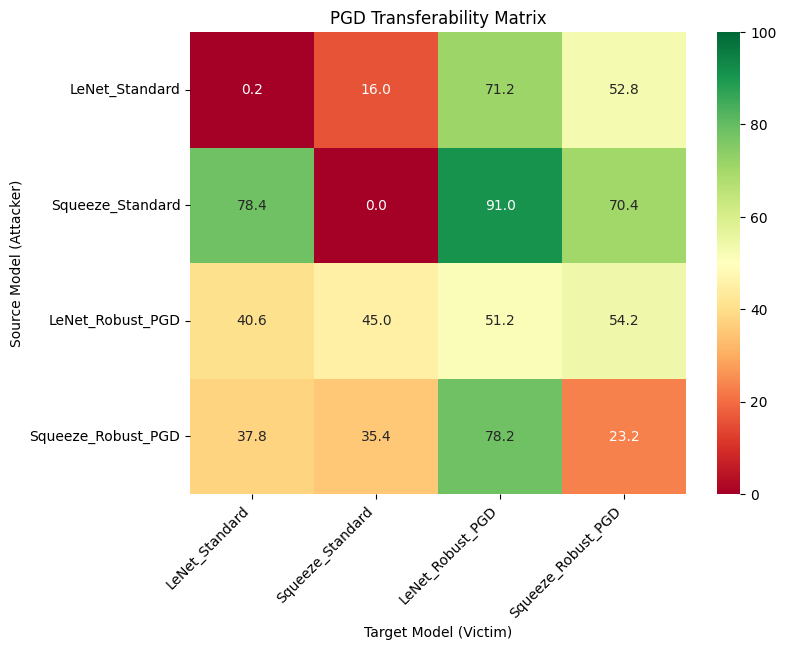

In [8]:
pgd_focus = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust_PGD', 'Squeeze_Robust_PGD']
pgd_metrics = calculate_metrics('PGD', pgd_focus)
pgd_ext_scores = get_external_scores(pgd_focus)

if pgd_metrics:
    x = np.arange(len(pgd_focus))
    width = 0.6
    bar_colors = ['#d3d3d3', '#d3d3d3', '#ff9999', '#ffcc99']

    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['clean'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pgd_focus)
    plt.title("PGD Baseline Clean Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['white'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pgd_focus)
    plt.title("PGD White-box Accuracy (Robustness)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['zoo_def'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pgd_focus)
    plt.title("PGD - Defense against PGD Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['zoo_off'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pgd_focus)
    plt.title("PGD - Offense Against Survey of Standard Models")
    plt.ylabel("Success Rate (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_ext_scores, color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pgd_focus)
    plt.title("PGD - Defense against Adversarial Dataset Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    focus_indices = [all_names.index(n) for n in pgd_focus]
    sub_matrix = pgd_metrics['matrix'][np.ix_(focus_indices, focus_indices)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
                xticklabels=pgd_focus, yticklabels=pgd_focus)
    plt.title("PGD Transferability Matrix")
    plt.xlabel("Target Model (Victim)")
    plt.ylabel("Source Model (Attacker)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Building Matrix: 100%|██████████| 4/4 [00:00<00:00, 23.68it/s]


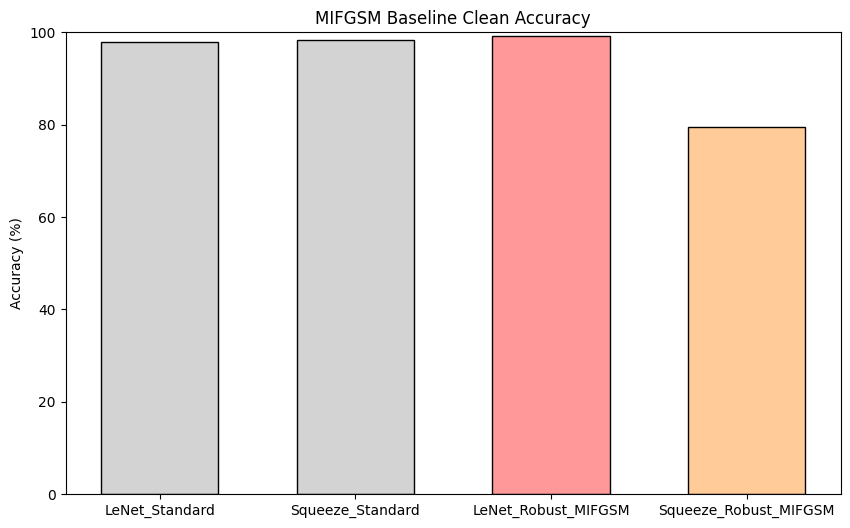

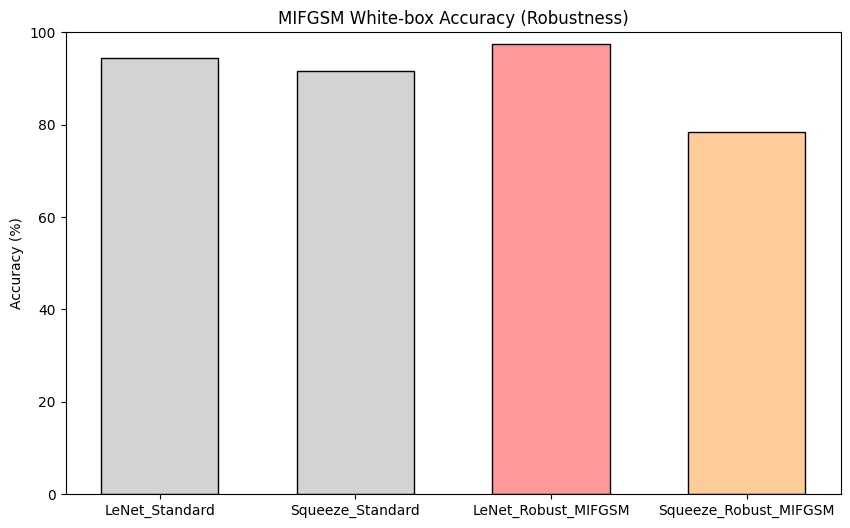

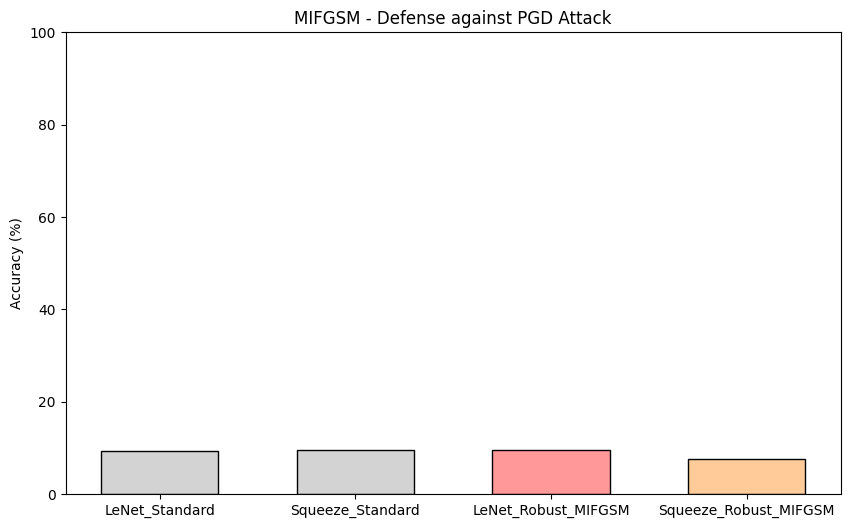

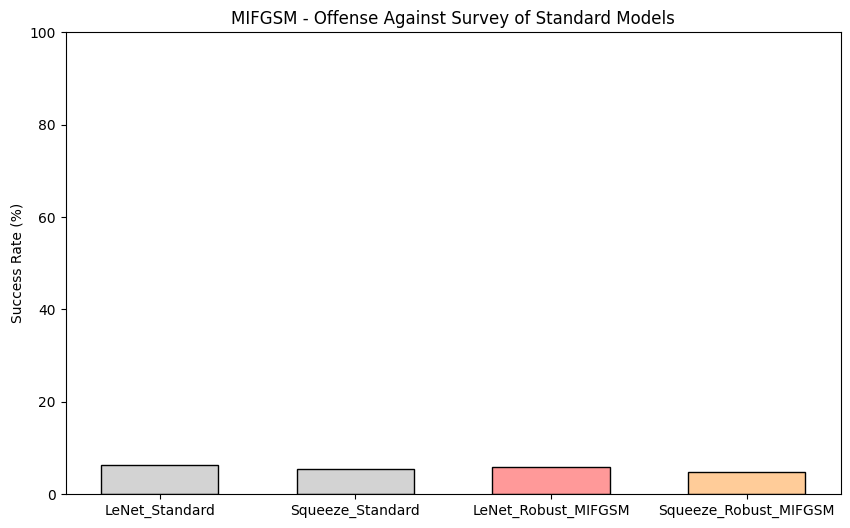

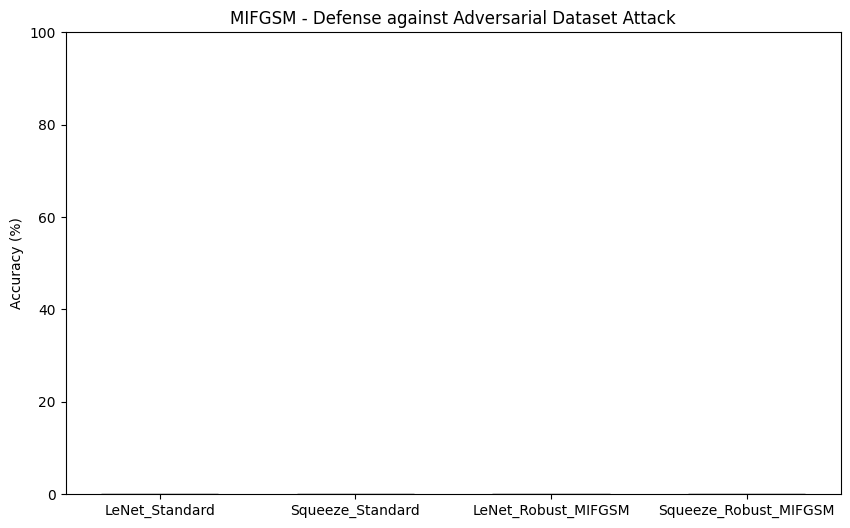

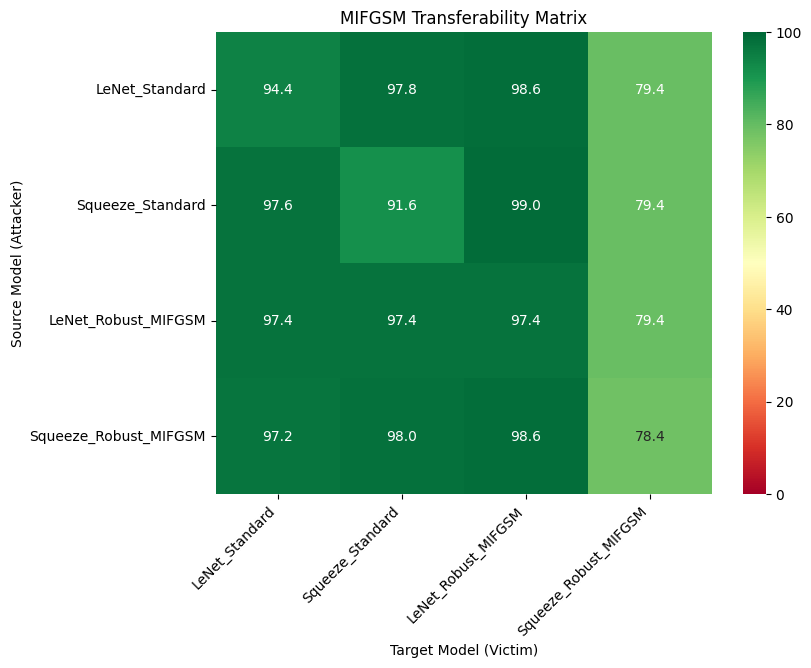

In [9]:
MIFGSM_focus = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust_MIFGSM', 'Squeeze_Robust_MIFGSM']
MIFGSM_metrics = calculate_metrics('MIFGSM', MIFGSM_focus)
MIFGSM_ext_scores = get_external_scores(MIFGSM_focus)

if MIFGSM_metrics:
    x = np.arange(len(MIFGSM_focus))
    width = 0.6
    bar_colors = ['#d3d3d3', '#d3d3d3', '#ff9999', '#ffcc99']

    plt.figure(figsize=(10, 6))
    plt.bar(x, MIFGSM_metrics['clean'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, MIFGSM_focus)
    plt.title("MIFGSM Baseline Clean Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, MIFGSM_metrics['white'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, MIFGSM_focus)
    plt.title("MIFGSM White-box Accuracy (Robustness)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, MIFGSM_metrics['zoo_def'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, MIFGSM_focus)
    plt.title("MIFGSM - Defense against PGD Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, MIFGSM_metrics['zoo_off'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, MIFGSM_focus)
    plt.title("MIFGSM - Offense Against Survey of Standard Models")
    plt.ylabel("Success Rate (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, MIFGSM_ext_scores, color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, MIFGSM_focus)
    plt.title("MIFGSM - Defense against Adversarial Dataset Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    focus_indices = [all_names.index(n) for n in MIFGSM_focus]
    sub_matrix = MIFGSM_metrics['matrix'][np.ix_(focus_indices, focus_indices)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
                xticklabels=MIFGSM_focus, yticklabels=MIFGSM_focus)
    plt.title("MIFGSM Transferability Matrix")
    plt.xlabel("Target Model (Victim)")
    plt.ylabel("Source Model (Attacker)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Building Matrix: 100%|██████████| 4/4 [00:00<00:00, 22.98it/s]


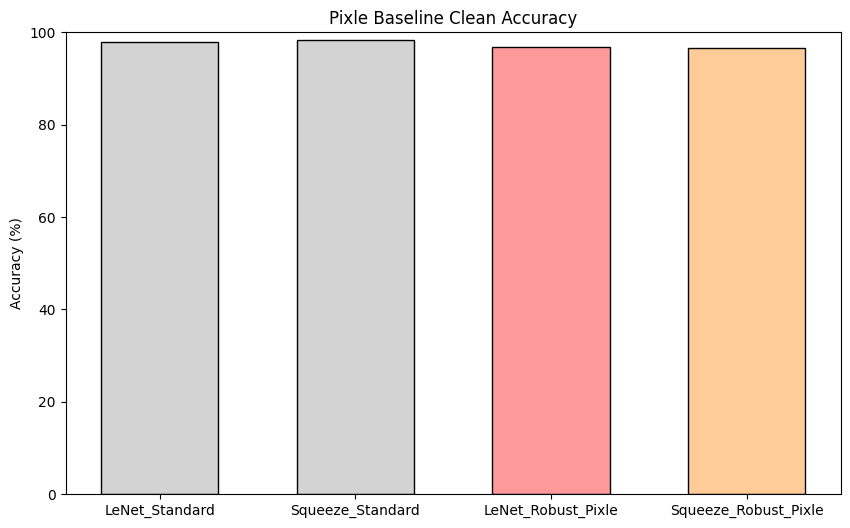

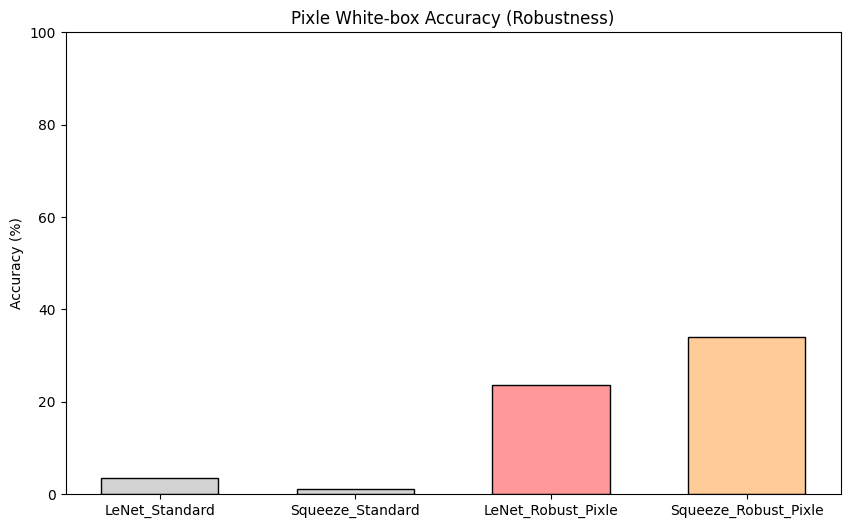

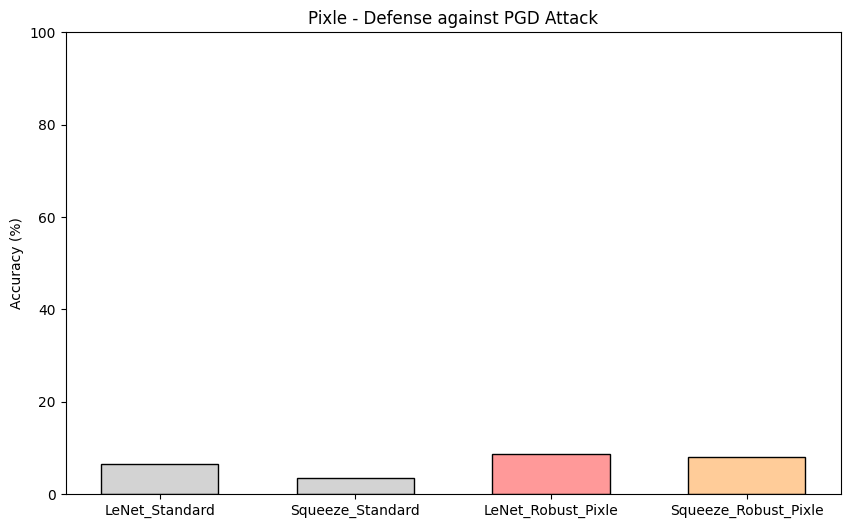

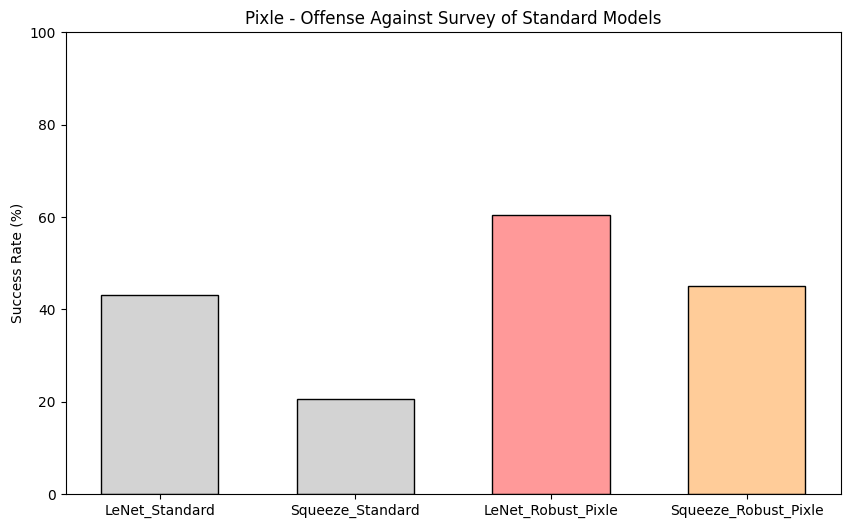

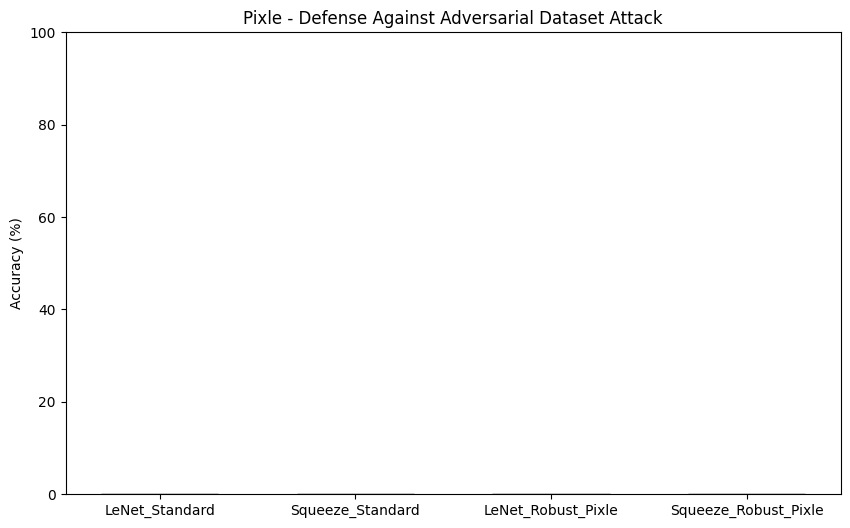

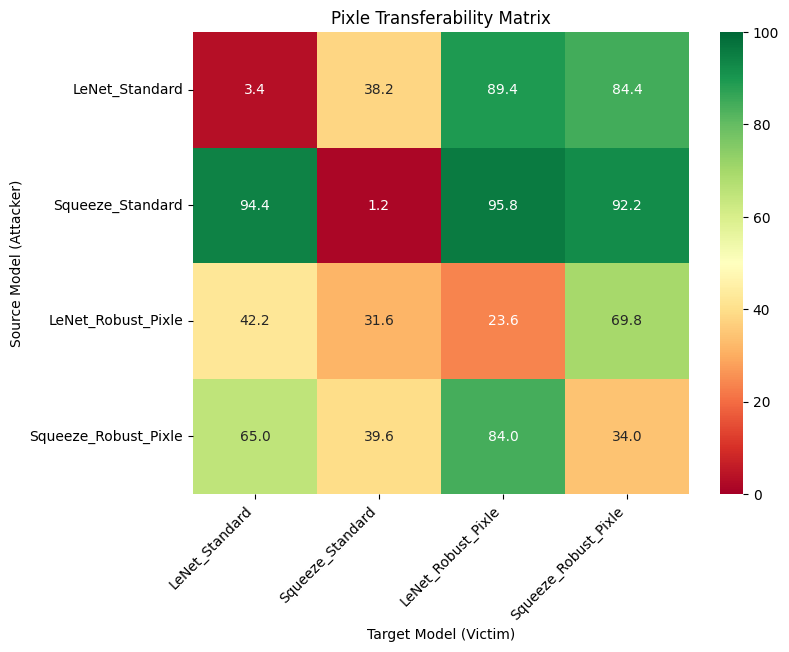

In [10]:
pixle_focus = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust_Pixle', 'Squeeze_Robust_Pixle']
pixle_metrics = calculate_metrics('Pixle', pixle_focus)
pixle_ext_scores = get_external_scores(pixle_focus)

if pixle_metrics:
    x = np.arange(len(pixle_focus))
    width = 0.6
    bar_colors = ['#d3d3d3', '#d3d3d3', '#ff9999', '#ffcc99']

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['clean'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pixle_focus)
    plt.title("Pixle Baseline Clean Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['white'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pixle_focus)
    plt.title("Pixle White-box Accuracy (Robustness)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['zoo_def'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pixle_focus)
    plt.title("Pixle - Defense against PGD Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['zoo_off'], color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pixle_focus)
    plt.title("Pixle - Offense Against Survey of Standard Models")
    plt.ylabel("Success Rate (%)")
    plt.ylim(0, 100)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_ext_scores, color=bar_colors, edgecolor='black', width=width)
    plt.xticks(x, pixle_focus)
    plt.title("Pixle - Defense Against Adversarial Dataset Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.show()

    focus_indices = [all_names.index(n) for n in pixle_focus]
    sub_matrix = pixle_metrics['matrix'][np.ix_(focus_indices, focus_indices)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
                xticklabels=pixle_focus, yticklabels=pixle_focus)
    plt.title("Pixle Transferability Matrix")
    plt.xlabel("Target Model (Victim)")
    plt.ylabel("Source Model (Attacker)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

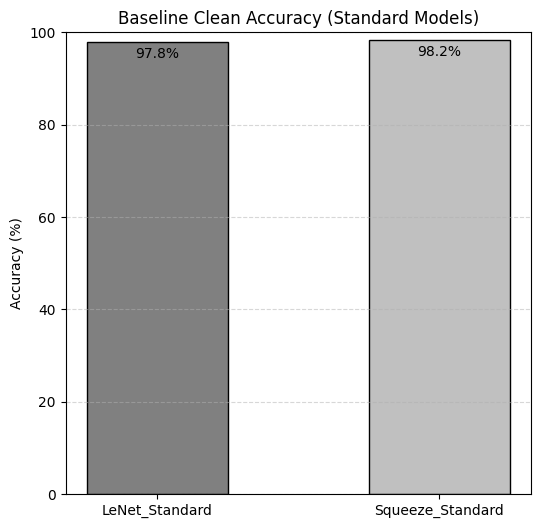

Baseline Clean Accuracy (Standard Models):
  LeNet_Standard: 97.80%
  Squeeze_Standard: 98.20%


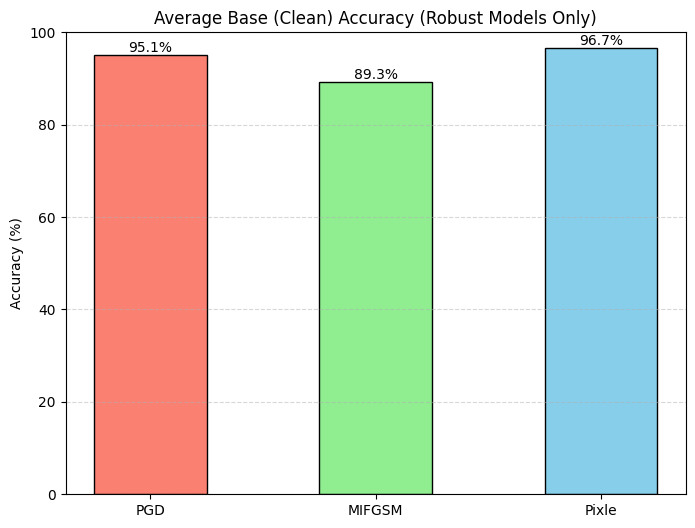

Average Base (Clean) Accuracy (Robust Models):
  PGD: 95.10%
  MIFGSM: 89.30%
  Pixle: 96.70%


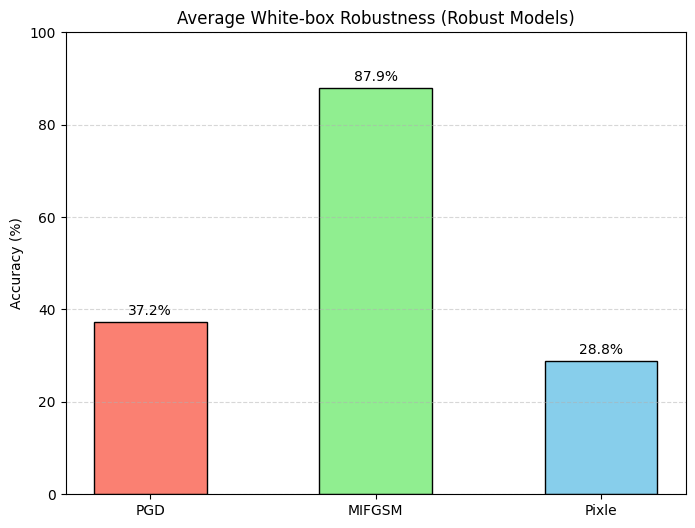

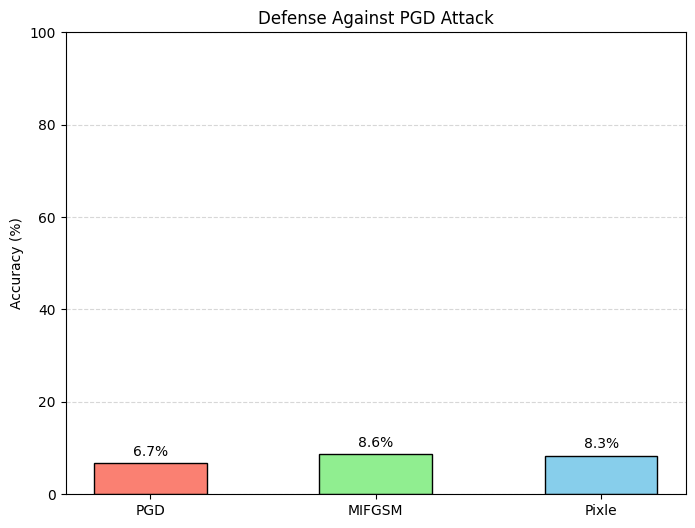

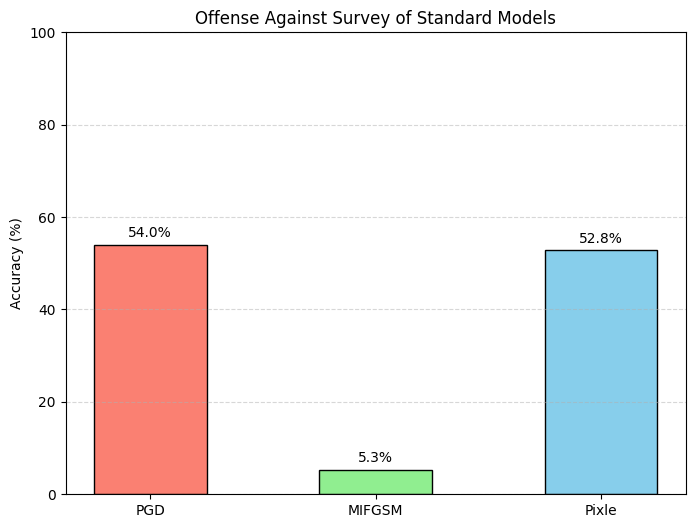

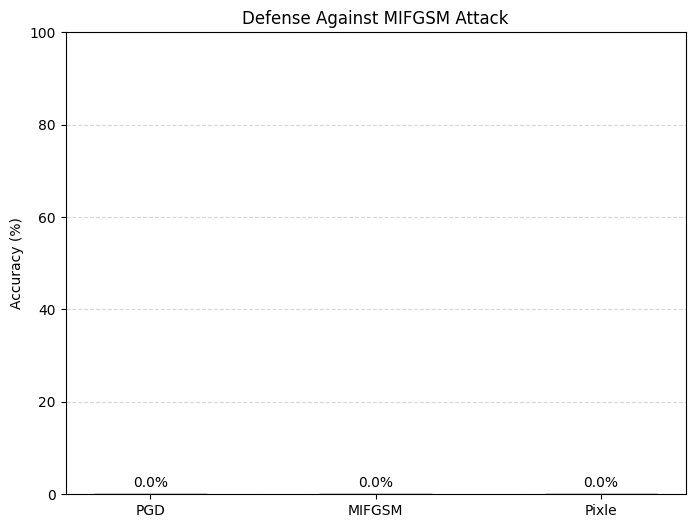

In [11]:
metrics_list = [pgd_metrics, MIFGSM_metrics, pixle_metrics]
ext_scores_list = [pgd_ext_scores, MIFGSM_ext_scores, pixle_ext_scores]
attack_names = ['PGD', 'MIFGSM', 'Pixle']
rob_indices = [2, 3] # Robust models are always at index 2 and 3 in the focus lists

std_indices = [0, 1]
std_names = ['LeNet_Standard', 'Squeeze_Standard']

if pgd_metrics:
    std_clean_scores = [pgd_metrics['clean'][i] for i in std_indices]
else:
    std_clean_scores = [0, 0]

plt.figure(figsize=(6, 6))
bars = plt.bar(std_names, std_clean_scores, color=['gray', 'silver'], edgecolor='black', width=0.5)
plt.title("Baseline Clean Accuracy (Standard Models)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 4, f"{yval:.1f}%", ha='center', va='bottom')

plt.show()

print("Baseline Clean Accuracy (Standard Models):")
for name, val in zip(std_names, std_clean_scores):
    print(f"  {name}: {val:.2f}%")

avg_clean_scores = []
for metrics in metrics_list:
    rob_clean = [metrics['clean'][i] for i in rob_indices]
    avg_clean_scores.append(np.mean(rob_clean))

plt.figure(figsize=(8, 6))
bars = plt.bar(attack_names, avg_clean_scores, color=['salmon', 'lightgreen', 'skyblue'], edgecolor='black', width=0.5)
plt.title("Average Base (Clean) Accuracy (Robust Models Only)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}%", ha='center', va='bottom')

plt.show()

print("Average Base (Clean) Accuracy (Robust Models):")
for atk, val in zip(attack_names, avg_clean_scores):
    print(f"  {atk}: {val:.2f}%")


if all(m is not None for m in metrics_list):

    def plot_robust_algo_summary(key, title, ylabel="Accuracy (%)"):
        avg_scores = []
        for metrics in metrics_list:
            rob_scores = [metrics[key][i] for i in rob_indices]
            avg_scores.append(np.mean(rob_scores))

        plt.figure(figsize=(8, 6))
        bars = plt.bar(attack_names, avg_scores, color=['salmon', 'lightgreen', 'skyblue'], edgecolor='black', width=0.5)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
        plt.show()

    plot_robust_algo_summary('white', "Average White-box Robustness (Robust Models)")
    plot_robust_algo_summary('zoo_def', "Defense Against PGD Attack")
    plot_robust_algo_summary('zoo_off', "Offense Against Survey of Standard Models")

    ext_avgs = []
    for scores in ext_scores_list:
        rob_avg = np.mean([scores[i] for i in rob_indices])
        ext_avgs.append(rob_avg)

    plt.figure(figsize=(8, 6))
    bars = plt.bar(attack_names, ext_avgs, color=['salmon', 'lightgreen', 'skyblue'], edgecolor='black', width=0.5)
    plt.title("Defense Against MIFGSM Attack")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
    plt.show()

Conducting Final White-Box Survey (100 samples per attack)...


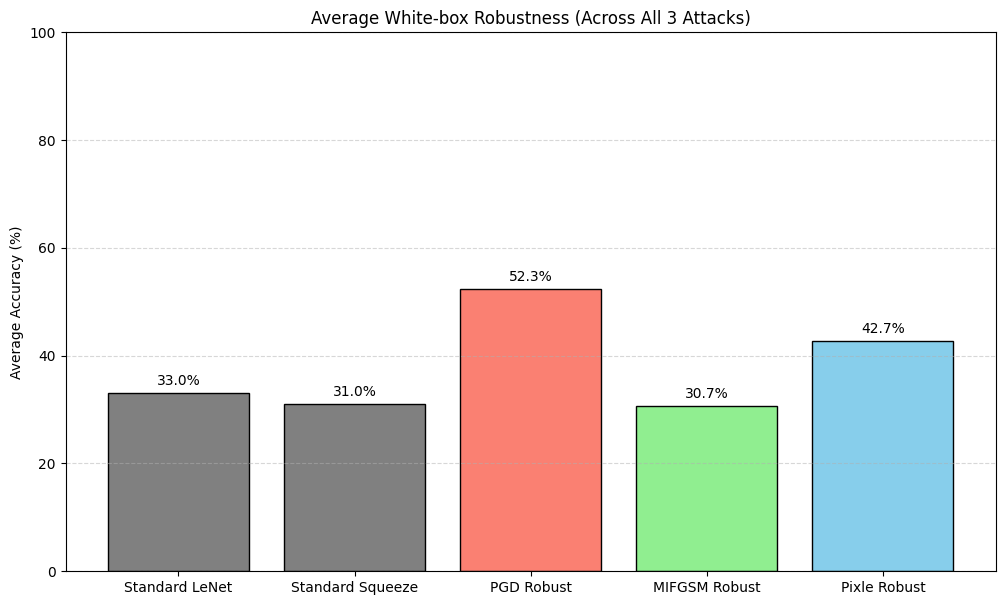

Final Survey Scores:
  Standard LeNet: 33.00%
  Standard Squeeze: 31.00%
  PGD Robust: 52.33%
  MIFGSM Robust: 30.67%
  Pixle Robust: 42.67%


In [12]:
survey_attacks = [
    ('PGD', PGD, {'eps': 0.3, 'alpha': 0.01, 'steps': 40}),
    ('MIFGSM', MIFGSM, {'c': 5, 'kappa': 0, 'steps': 1000, 'lr': 0.01}),
    ('Pixle', Pixle, {'restarts': 10})
]

groups = {
    'Standard LeNet': ['LeNet_Standard'],
    'Standard Squeeze': ['Squeeze_Standard'],
    'PGD Robust': ['LeNet_Robust_PGD', 'Squeeze_Robust_PGD'],
    'MIFGSM Robust': ['LeNet_Robust_MIFGSM', 'Squeeze_Robust_MIFGSM'],
    'Pixle Robust': ['LeNet_Robust_Pixle', 'Squeeze_Robust_Pixle']
}

final_results = {}
detailed_survey_results = {g: {'PGD': [], 'MIFGSM': [], 'Pixle': []} for g in groups}

print("Conducting Final White-Box Survey (100 samples per attack)...")

for group_name, model_names in groups.items():
    group_all_accs = []

    for name in model_names:
        if name not in zoo_models:
            continue
        model = zoo_models[name]

        for atk_name, atk_class, atk_params in survey_attacks:
            try:
                adversary = atk_class(model, **atk_params)
            except:
                adversary = atk_class(model)

            advs = []
            lbls = []
            for data, target in test_loader:
                if len(advs) * data.shape[0] >= 100: break
                data, target = data.to(device), target.to(device)
                adv = adversary(data, target)
                advs.append(adv)
                lbls.append(target)

            adv_imgs = torch.cat(advs)[:100]
            labels = torch.cat(lbls)[:100]

            with torch.no_grad():
                preds = model(adv_imgs).argmax(1)
                acc = (preds == labels).float().mean().item() * 100
                detailed_survey_results[group_name][atk_name].append(acc)
                group_all_accs.append(acc)

    if group_all_accs:
        final_results[group_name] = np.mean(group_all_accs)
    else:
        final_results[group_name] = 0

plt.figure(figsize=(12, 7))
bars = plt.bar(final_results.keys(), final_results.values(), color=['gray', 'gray', 'salmon', 'lightgreen', 'skyblue'], edgecolor='black')
plt.title("Average White-box Robustness (Across All 3 Attacks)")
plt.ylabel("Average Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.show()

print("Final Survey Scores:")
for k, v in final_results.items():
    print(f"  {k}: {v:.2f}%")

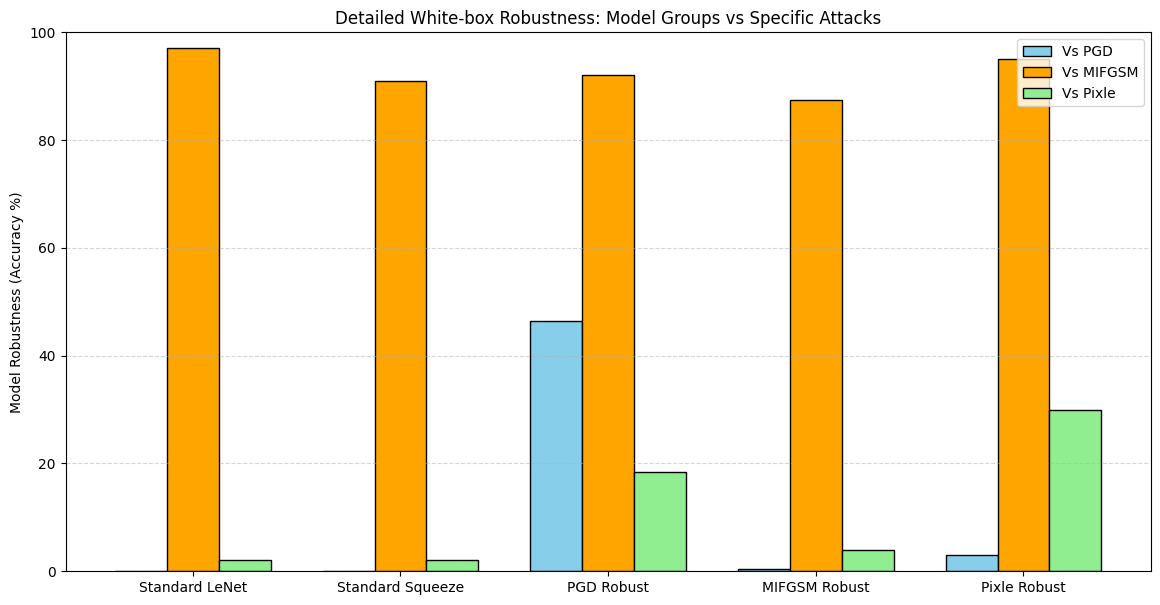

Detailed Scores (Accuracy):
Standard LeNet:
  Vs PGD:   0.00%
  Vs MIFGSM:    97.00%
  Vs Pixle: 2.00%
Standard Squeeze:
  Vs PGD:   0.00%
  Vs MIFGSM:    91.00%
  Vs Pixle: 2.00%
PGD Robust:
  Vs PGD:   46.50%
  Vs MIFGSM:    92.00%
  Vs Pixle: 18.50%
MIFGSM Robust:
  Vs PGD:   0.50%
  Vs MIFGSM:    87.50%
  Vs Pixle: 4.00%
Pixle Robust:
  Vs PGD:   3.00%
  Vs MIFGSM:    95.00%
  Vs Pixle: 30.00%


In [13]:
group_labels = list(detailed_survey_results.keys())
pgd_scores = [np.mean(detailed_survey_results[g]['PGD']) if detailed_survey_results[g]['PGD'] else 0 for g in group_labels]
MIFGSM_scores = [np.mean(detailed_survey_results[g]['MIFGSM']) if detailed_survey_results[g]['MIFGSM'] else 0 for g in group_labels]
pixle_scores = [np.mean(detailed_survey_results[g]['Pixle']) if detailed_survey_results[g]['Pixle'] else 0 for g in group_labels]

x = np.arange(len(group_labels))
width = 0.25

plt.figure(figsize=(14, 7))
plt.bar(x - width, pgd_scores, width, label='Vs PGD', color='skyblue', edgecolor='black')
plt.bar(x, MIFGSM_scores, width, label='Vs MIFGSM', color='orange', edgecolor='black')
plt.bar(x + width, pixle_scores, width, label='Vs Pixle', color='lightgreen', edgecolor='black')

plt.xticks(x, group_labels)
plt.ylabel("Model Robustness (Accuracy %)")
plt.title("Detailed White-box Robustness: Model Groups vs Specific Attacks")
plt.legend()
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Detailed Scores (Accuracy):")
for g in group_labels:
    print(f"{g}:")
    print(f"  Vs PGD:   {np.mean(detailed_survey_results[g]['PGD']):.2f}%")
    print(f"  Vs MIFGSM:    {np.mean(detailed_survey_results[g]['MIFGSM']):.2f}%")
    print(f"  Vs Pixle: {np.mean(detailed_survey_results[g]['Pixle']):.2f}%")

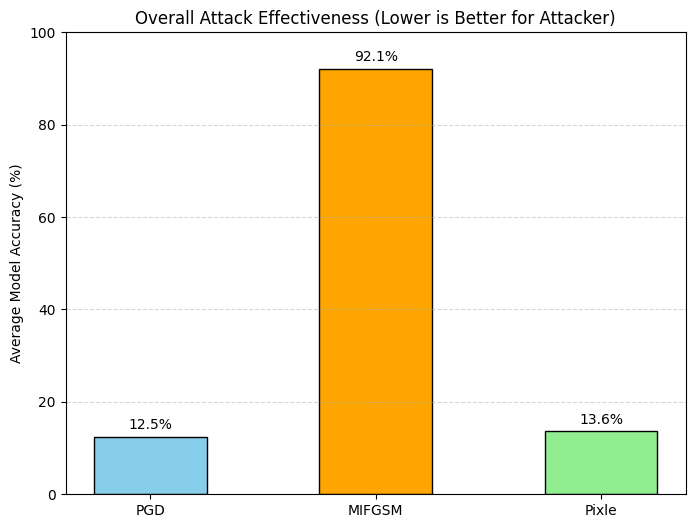

Overall Attack Performance (Average Accuracy Allowed):
  PGD: 12.50%
  MIFGSM: 92.12%
  Pixle: 13.62%


In [14]:
all_pgd_vals = []
all_MIFGSM_vals = []
all_pixle_vals = []

for g in detailed_survey_results:
    all_pgd_vals.extend(detailed_survey_results[g]['PGD'])
    all_MIFGSM_vals.extend(detailed_survey_results[g]['MIFGSM'])
    all_pixle_vals.extend(detailed_survey_results[g]['Pixle'])

avg_pgd_effectiveness = np.mean(all_pgd_vals) if all_pgd_vals else 0
avg_MIFGSM_effectiveness = np.mean(all_MIFGSM_vals) if all_MIFGSM_vals else 0
avg_pixle_effectiveness = np.mean(all_pixle_vals) if all_pixle_vals else 0

attack_avgs = [avg_pgd_effectiveness, avg_MIFGSM_effectiveness, avg_pixle_effectiveness]
attack_labels = ['PGD', 'MIFGSM', 'Pixle']

plt.figure(figsize=(8, 6))
bars = plt.bar(attack_labels, attack_avgs, color=['skyblue', 'orange', 'lightgreen'], edgecolor='black', width=0.5)

plt.title("Overall Attack Effectiveness (Lower is Better for Attacker)")
plt.ylabel("Average Model Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')

plt.show()

print("Overall Attack Performance (Average Accuracy Allowed):")
for atk, score in zip(attack_labels, attack_avgs):
    print(f"  {atk}: {score:.2f}%")

In [15]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchattacks import PGD, MIFGSM, Pixle
import os
from tqdm import tqdm

# Define Args class to replace argparse for Notebook execution
class Args:
    model = 'lenet'         # Set model to LeNet
    batch_size = 128
    epochs = 10              # Set to 1 epoch for demonstration (MIFGSM training is slow)
    lr = 0.01
    robust = True           # Enable robust training
    attack = 'MIFGSM'           # Set attack to MIFGSM

args = Args()

# Helper function to load data (replacing load_MNIST_data import)
def getMNISTDataLoaders(batchSize):
    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Split train into train/val
    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = getMNISTDataLoaders(batchSize=args.batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model based on args
if args.model == 'squeezenet':
    model = SqueezeNetMNIST()
elif args.model == 'lenet':
    model = LeNet5()

model = model.to(device)

xent_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)

print(f"Using device: {device}")
print(f"Starting training for {args.model} with {args.attack} attack (Robust={args.robust})")

model.train()
n_epochs = args.epochs
lr = args.lr

for i in range(n_epochs):
    for j, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {i+1}/{n_epochs}'):
        images, labels = images.to(device), labels.to(device)

        if args.robust:
            model.eval()
            if args.attack == 'MIFGSM':
                # Note: MIFGSM with 250 steps is very computationally expensive inside a training loop.
                attack = MIFGSM(model, eps=0.3, alpha=0.01, steps=7, decay=1.0)
            adv_images = attack(images, labels)
            model.train()

        optimizer.zero_grad()
        outputs = model(torch.cat((adv_images, images), 0) if args.robust else images)
        loss = xent_loss(outputs, torch.cat((labels, labels), 0) if args.robust else labels)
        loss.backward()
        optimizer.step()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

os.makedirs('models', exist_ok=True)
if args.robust:
    torch.save(model.state_dict(), f'models/{args.model}_mnist_robust_{args.attack}.pth')
else:
    torch.save(model.state_dict(), f'models/{args.model}_mnist_normal.pth')

print(f'Accuracy of the model on the test images: {100 * correct / total} %')

Using device: cuda
Starting training for lenet with MIFGSM attack (Robust=True)


Epoch 10/10: 100%|██████████| 422/422 [00:10<00:00, 39.91it/s]


Accuracy of the model on the test images: 95.32 %


In [16]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchattacks import PGD, MIFGSM, Pixle
import os
from tqdm import tqdm

# Define Args class to replace argparse for Notebook execution
class Args:
    model = 'squeezenet'         # Set model to LeNet
    batch_size = 128
    epochs = 10              # Set to 1 epoch for demonstration (MIFGSM training is slow)
    lr = 0.01
    robust = True           # Enable robust training
    attack = 'mifgsm'           # Set attack to MIFGSM

args = Args()

# Helper function to load data (replacing load_MNIST_data import)
def getMNISTDataLoaders(batchSize):
    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Split train into train/val
    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = getMNISTDataLoaders(batchSize=args.batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model based on args
if args.model == 'squeezenet':
    model = SqueezeNetMNIST()
elif args.model == 'lenet':
    model = LeNet5()

model = model.to(device)

xent_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)

print(f"Using device: {device}")
print(f"Starting training for {args.model} with {args.attack} attack (Robust={args.robust})")

model.train()
n_epochs = args.epochs
lr = args.lr

for i in range(n_epochs):
    for j, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {i+1}/{n_epochs}'):
        images, labels = images.to(device), labels.to(device)

        if args.robust:
            model.eval()
            if args.attack == 'MIFGSM':
                # Note: MIFGSM with 250 steps is very computationally expensive inside a training loop.
                attack = MIFGSM(model, c=5, kappa=0, steps=250, lr=0.01)
            adv_images = attack(images, labels)
            model.train()

        optimizer.zero_grad()
        outputs = model(torch.cat((adv_images, images), 0) if args.robust else images)
        loss = xent_loss(outputs, torch.cat((labels, labels), 0) if args.robust else labels)
        loss.backward()
        optimizer.step()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

os.makedirs('models', exist_ok=True)
if args.robust:
    torch.save(model.state_dict(), f'models/{args.model}_mnist_robust_{args.attack}.pth')
else:
    torch.save(model.state_dict(), f'models/{args.model}_mnist_normal.pth')

print(f'Accuracy of the model on the test images: {100 * correct / total} %')

Using device: cuda
Starting training for squeezenet with mifgsm attack (Robust=True)


Epoch 10/10: 100%|██████████| 422/422 [00:13<00:00, 30.42it/s]


Accuracy of the model on the test images: 98.47 %


Missing saved adversarial files (not fatal, but those entries won't appear):
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_MIFGSM_lenet_pgd.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_Pixle_lenet_pgd.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_MIFGSM_squeezenet_pgd.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_Pixle_squeezenet_pgd.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_PGD_lenet_mifgsm.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_Pixle_lenet_mifgsm.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_PGD_squeezenet_mifgsm.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_Pixle_squeezenet_mifgsm.pth
   /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_PGD_lenet_pix

,model,attack,n,l2_mean,l2_std,l2_median
1,lenet,MIFGSM,500,0.656562,0.025914,0.654285
0,lenet,PGD,500,5.657249,0.276396,5.615222
2,lenet,Pixle,500,6.803217,2.003519,6.767690
8,lenet_mifgsm,MIFGSM,500,0.668409,0.018710,0.669504
6,lenet_pgd,PGD,500,4.893041,0.285207,4.887110
10,lenet_pixle,Pixle,500,7.573257,2.071828,7.690972
4,squeezenet,MIFGSM,500,0.630937,0.017597,0.631519
3,squeezenet,PGD,500,4.809844,0.177930,4.819130
5,squeezenet,Pixle,500,5.725239,1.679763,5.768385
9,squeezenet_mifgsm,MIFGSM,500,0.510272,0.248543,0.623301


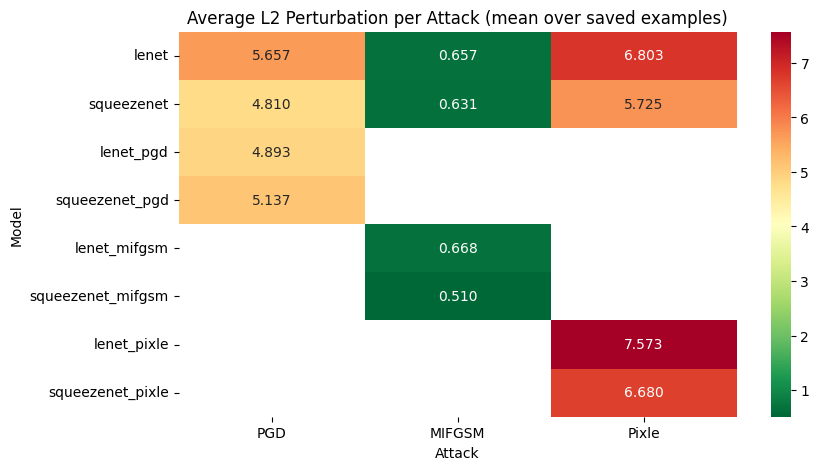

In [22]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

focus_models = [
    ("lenet.pth", "lenet"),
    ("squeezenet.pth", "squeezenet"),
    ("lenet_pgd.pth", "lenet_pgd"),
    ("squeezenet_pgd.pth", "squeezenet_pgd"),
    ("lenet_mifgsm.pth", "lenet_mifgsm"),
    ("squeezenet_mifgsm.pth", "squeezenet_mifgsm"),
    ("lenet_pixle.pth", "lenet_pixle"),
    ("squeezenet_pixle.pth", "squeezenet_pixle"),
]

attacks = ["PGD", "MIFGSM", "Pixle"]

def l2_per_example(clean, adv):
    diff = (adv - clean).reshape(clean.shape[0], -1)
    return torch.norm(diff, p=2, dim=1)

rows = []
missing = []

for fname, model_label in focus_models:
    for atk in attacks:
        path = f"{adv_dir}/500_adv_{atk}_{fname}"
        if not os.path.exists(path):
            missing.append(path)
            continue

        blob = torch.load(path, map_location="cpu")
        clean = blob["clean"].float()
        adv = blob["adv"].float()

        n = min(clean.shape[0], adv.shape[0])
        clean = clean[:n]
        adv = adv[:n]

        l2 = l2_per_example(clean, adv).numpy()
        rows.append({
            "model": model_label,
            "attack": atk,
            "n": int(n),
            "l2_mean": float(np.mean(l2)),
            "l2_std": float(np.std(l2)),
            "l2_median": float(np.median(l2)),
        })

df = pd.DataFrame(rows)

if missing:
    print("Missing saved adversarial files (not fatal, but those entries won't appear):")
    for m in missing[:20]:
        print("  ", m)
    if len(missing) > 20:
        print(f"  ... (+{len(missing)-20} more)")

display(df.sort_values(["model", "attack"]))

pivot = df.pivot(index="model", columns="attack", values="l2_mean").reindex(
    index=[m for _, m in focus_models], columns=attacks
)

plt.figure(figsize=(9, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn_r")
plt.title("Average L2 Perturbation per Attack (mean over saved examples)")
plt.ylabel("Model")
plt.xlabel("Attack")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()